In [341]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import confusion_matrix

In [303]:
# find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	for i in range(len(dataset[0])-1):
		col_values = [row[i] for row in dataset]
		value_min = min(col_values)
		value_max = max(col_values)
		minmax.append([value_min, value_max])
	return minmax
 
# rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])


# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
  distance = 0.0
  for i in range(len(row1)-1):
    distance += (row1[i] - row2[i])**2
  return np.sqrt(distance)


# locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors
 
# make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

In [317]:
names = ['doggo', 'not edgy', 'i feel like', 'untitled', 'whatever simulation', 'never forget', 'b', '떡볶이']
columns = ['energy', 'loudness', 'tempo', 'valence', 'danceability', 'playlist']

tracks_all = pd.DataFrame(columns=columns)
for name in names:
  df = pd.read_csv(name+'.csv', index_col=0).iloc[:, 5:10]
  if name=='떡볶이':
    df['playlist'] = 'tteokbokki'
  else:
    df['playlist'] = name
  tracks_all = tracks_all.append(df, ignore_index=True)

# drop last track if total number of tracks not even
if len(tracks_all)%2 != 0:
  tracks_all = tracks_all.drop([len(tracks_all)-1])

tracks_all

,energy,loudness,tempo,valence,danceability,playlist
0,0.933,-3.476,170.130,0.708,0.501,doggo
1,0.934,-3.347,169.907,0.591,0.513,doggo
2,0.946,-4.134,145.004,0.621,0.600,doggo
3,0.913,-3.493,156.076,0.409,0.538,doggo
4,0.970,-2.512,170.190,0.431,0.425,doggo
...,...,...,...,...,...,...
917,0.772,-3.272,141.968,0.610,0.799,tteokbokki
918,0.851,-2.972,93.208,0.752,0.656,tteokbokki
919,0.732,-4.865,82.026,0.436,0.665,tteokbokki
920,0.907,-2.487,120.069,0.778,0.739,tteokbokki


In [342]:
# sample 50% observations as training data
train = random.sample(range(0, len(tracks_all)), len(tracks_all)//2)
ttrain = tracks_all.index.isin(train)

tracks_train = tracks_all[ttrain]

# rest 50% as test data
tracks_test = tracks_all[~ttrain]

In [343]:
# create response vectors and design matrices for training and test set
YTrain = tracks_train['playlist'].tolist()
XTrain = tracks_train.drop('playlist', axis=1).values.tolist()

YTest = tracks_test['playlist'].tolist()
XTest = tracks_test.drop('playlist', axis=1).values.tolist()

tracks_train_values = tracks_train.values.tolist()

In [350]:
# normalize datasets
normalize_dataset(tracks_train_values, dataset_minmax(tracks_train_values))
normalize_dataset(XTrain, dataset_minmax(XTrain))
normalize_dataset(XTest, dataset_minmax(XTest))

In [408]:
pred_labels = []
for row in XTrain:
  pred_labels.append(predict_classification(tracks_train_values, row, 2))
len(pred_labels)

matrix = confusion_matrix(YTrain, pred_labels, labels=names)
np.trace(matrix)/np.sum(matrix)

0.702819956616052

In [405]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

pred_labels = []
for row in XTest:
  pred_labels.append(predict_classification(tracks_train_values, row, 25))
len(pred_labels)

matrix = confusion_matrix(YTest, pred_labels, labels=names)
matrix

array([[  2,  39,   0,   0,   4,   0,   0,   8],
       [  1, 126,   0,   0,  10,   4,   0,  11],
       [  2,  47,   0,   0,   3,   0,   0,   9],
       [  0,  17,   0,   1,   3,   1,   0,   2],
       [  2,  15,   0,   0,   9,   1,   0,   6],
       [  3,  23,   0,   0,   7,   8,   0,   5],
       [  2,   8,   0,   0,   8,   0,   0,   3],
       [  0,  21,   0,   0,   5,   0,   0,  45]])

In [407]:
np.trace(matrix)/np.sum(matrix)

0.41431670281995664

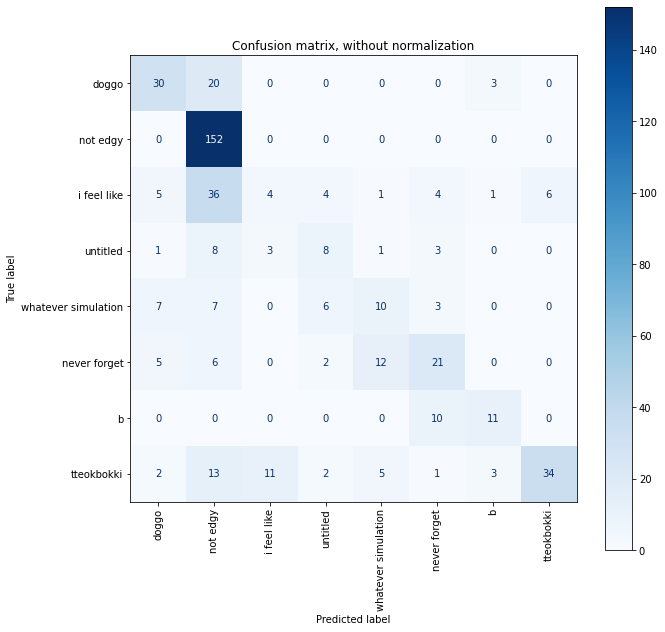

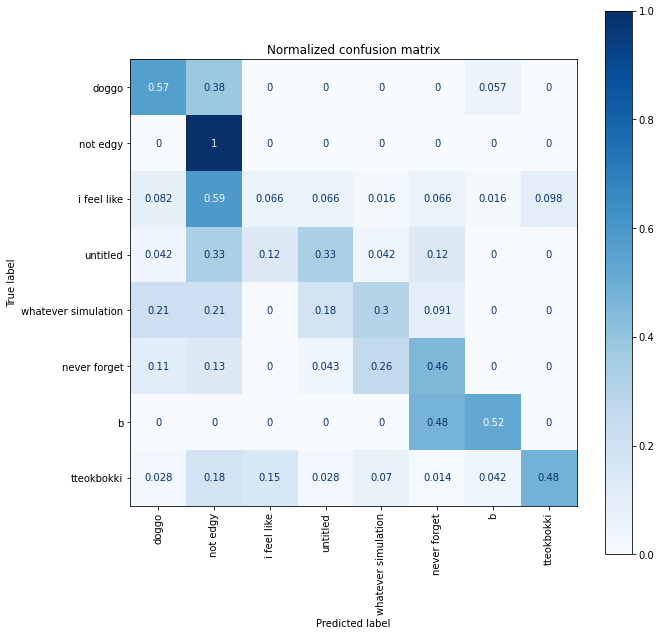

In [409]:
names[-1] = 'tteokbokki'
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay.from_predictions(
      YTest,
      pred_labels,
      labels=names,
      xticks_rotation='vertical',
      normalize=normalize,
      cmap=plt.cm.Blues,
      ax=ax)
  disp.ax_.set_title(title)
plt.show()